In [1]:
import pickle
import sys
from tqdm import tqdm
import numpy as np
sys.path.append('..')
import eval
import numpy as np
import random

In [2]:
DATASET = "feature_norms" # "feature_norms", "memory_colors"

In [4]:
noun2prop = pickle.load(open(f"../data/datasets/{DATASET}/noun2property/noun2prop.p", "rb"))
gpt3_predicts = {line.split()[0]:line.split()[1:] for line in open(f"../data/datasets/{DATASET}/GPT3/gpt3_predicts.txt", "r").readlines()}
roberta_predicts = pickle.load(open(f"../output/output_{DATASET}/roberta-large+singular_generally.p", "rb"))
bert_predicts = pickle.load(open(f"../output/output_{DATASET}/bert-large-uncased+plural_most.p", "rb"))
clip_predicts = pickle.load(open(f"../output/output_{DATASET}/clip_scores.p", "rb"))
combined_predicts = pickle.load(open(f"../data/datasets/{DATASET}/CEM/combine_scores.p", "rb"))
vilt_predicts = pickle.load(open(f'../output/output_{DATASET}/vilt+plural+10.p', "rb"))
gpt_predicts = pickle.load(open(f"../output/output_{DATASET}/gpt2-large+plural_most.p", "rb"))
pred_combined_predicts = pickle.load(open(f"../output/output_{DATASET}/pred_combined_scores.p", "rb"))
candidate_adjs = []
for noun, props in noun2prop.items():
    candidate_adjs += props
candidate_adjs = list(set(candidate_adjs))

from difflib import SequenceMatcher
def similar(a, b):
    return SequenceMatcher(None, a, b).ratio()
    
concreteness = {w: c / 5 for w, c in pickle.load(open("../data/concreteness/word2concreteness.M.p", "rb")).items()}
all_words = list(concreteness.keys())
prop2concretness = {}
for prop in tqdm(candidate_adjs):
    if prop in concreteness:
        prop2concretness[prop] = concreteness[prop]
    else:
        sims = []
        for word in all_words:
            sims.append((word, similar(word, prop)))
        sims.sort(key=lambda x: x[1], reverse=True)
        prop2concretness[prop] = concreteness[sims[0][0]]

100%|██████████| 209/209 [00:11<00:00, 18.05it/s]


In [5]:
for noun,prop in clip_predicts.items():
    clip_predicts[noun] = [p[0] for p in prop]

In [6]:
noun2prop_most_concrete = {}
noun2prop_least_concrete = {}
noun2prop_random_concrete = [{} for _ in range(10)]
for noun, props in noun2prop.items():
    prop_w_concretness = [(prop, prop2concretness[prop]) for prop in props]
    prop_w_concretness.sort(key=lambda x: x[1])
    noun2prop_most_concrete[noun] = [prop_w_concretness[-1][0]]
    noun2prop_least_concrete[noun] = [prop_w_concretness[0][0]]
    # noun2prop_random_concrete[noun] = [random.choice(props)]

In [7]:
for i in range(10):
    for noun, props in noun2prop.items():
        noun2prop_random_concrete[i][noun] = [random.choice(props)]

In [8]:
ys = {}
err = {}
for model, noun2predicts in {"BERT": bert_predicts, "RoBERTa": roberta_predicts, "GPT2": gpt_predicts, "GPT3": gpt3_predicts, "ViLT": vilt_predicts, "CLIP": clip_predicts, "CEM-Gold": combined_predicts, 'CEM-Pred': pred_combined_predicts}.items():
    ys[model] = []
    noun2props = [noun2prop_most_concrete, noun2prop_least_concrete, noun2prop_random_concrete]
    for i in range(3):
        noun2prop_test = noun2props[i]
        for k in [1]:
            if i == 2:
                values = []
                for j in range(10):
                    values.append(eval.evaluate_acc(noun2predicts, noun2prop_test[j], k, False)*100)
                ys[model].append(np.mean(values))
                err[model] = np.std(values)
            else:
                ys[model].append(eval.evaluate_acc(noun2predicts, noun2prop_test, k, True)*100)

# for k in [1, 5, 10]:
#     eval.evaluate_precision(noun2predicts, noun2prop_test, k, True)

# for k in [1, 5, 10]:
#     eval.evaluate_recall(noun2predicts, noun2prop_test, k, True)

top1 acc:  0.0825147347740668
top1 acc:  0.08447937131630648
top1 acc:  0.060903732809430254
top1 acc:  0.09430255402750491
top1 acc:  0.07269155206286837
top1 acc:  0.09233791748526522
top1 acc:  0.17485265225933203
top1 acc:  0.11394891944990176
top1 acc:  0.19646365422396855
top1 acc:  0.03929273084479371
top1 acc:  0.1237721021611002
top1 acc:  0.07072691552062868
top1 acc:  0.1807465618860511
top1 acc:  0.11787819253438114
top1 acc:  0.19646365422396855
top1 acc:  0.13555992141453832


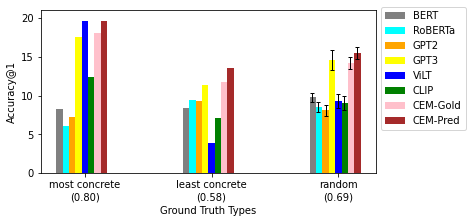

In [61]:
import matplotlib.pyplot as plt
import numpy as np

plt.rcParams["figure.figsize"] = (6,3)
# create data
x = 2 * np.arange(3)

ax = plt.subplot(111)

width = 0.1

# plot data in grouped manner of bar type
models = list(ys.keys())
y_v = list(ys.values())
errs = list(err.values())
plt.bar(x-0.4, y_v[0], width, color='grey')
plt.bar(x-0.3, y_v[1], width, color='cyan')
plt.bar(x-0.2, y_v[2], width, color='orange')
plt.bar(x-0.1, y_v[3], width, color='yellow')
plt.bar(x, y_v[4], width, color='blue')
plt.bar(x+0.1, y_v[5], width, color='green')
plt.bar(x+0.2, y_v[6], width, color='pink')
plt.bar(x+0.3, y_v[7], width, color='brown')

plt.errorbar(x[2]-0.42, y_v[0][2], yerr =errs[0],capsize=2,  elinewidth = 1, fmt = '-',color = 'black',)
plt.errorbar(x[2]-0.325, y_v[1][2], yerr =errs[1],capsize=2,  elinewidth = 1, fmt = '-',color = 'black',)
plt.errorbar(x[2]-0.2, y_v[2][2], yerr =errs[2],capsize=2,  elinewidth = 1, fmt = '-',color = 'black',)
plt.errorbar(x[2]-0.1, y_v[3][2], yerr =errs[3],capsize=2,  elinewidth = 1, fmt = '-',color = 'black',)
plt.errorbar(x[2], y_v[4][2], yerr =errs[4],capsize=2,  elinewidth = 1, fmt = '-',color = 'black',)
plt.errorbar(x[2]+0.09, y_v[5][2], yerr =errs[5],capsize=2,  elinewidth = 1, fmt = '-',color = 'black',)
plt.errorbar(x[2]+0.19, y_v[6][2], yerr =errs[6],capsize=2,  elinewidth = 1, fmt = '-',color = 'black',)
plt.errorbar(x[2]+0.3, y_v[7][2], yerr =errs[7],capsize=2,  elinewidth = 1, fmt = '-',color = 'black',)

plt.xticks(x, ["most concrete\n(0.80)", "least concrete\n(0.58)", "random\n(0.69)"])
plt.xlabel("Ground Truth Types")
plt.ylabel("Accuracy@1")
plt.legend(models, bbox_to_anchor=(1, 1.05))
plt.ylim(0,21)
plt.savefig('distribution.pdf', format='pdf', dpi=600, bbox_inches='tight')
plt.show()